# Prediction #

After a first check on the data, using ordinal regressions and linear regressions, we can add new variables we've seen can help with prediction and use them with more complex models such as tree based or mlp models.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression, PoissonRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from xgboost import XGBClassifier
import seaborn as sns

In [101]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [102]:
train.drop(['home_formation', 'away_fromation'], axis=1, inplace=True)
test.drop(['home_formation', 'away_fromation'], axis=1, inplace=True)

In [103]:
cols_to_keep = ['home_score','away_score','home_team_name', 'away_team_name',
                'HomePlayer_Overall_mean', 'HomePlayer_Overall_min',
                  'HomePlayer_Overall_max', 'AwayPlayer_Overall_mean', 
                'AwayPlayer_Overall_min', 'AwayPlayer_Overall_max', 
                'home_Points_prior', 'away_Points_prior', 'HomePlayer_Overall_sd',
                'AwayPlayer_Overall_sd','HomePlayer_Overall_mean_ln', 'HomePlayer_Overall_mean_sqrt',
                'AwayPlayer_Overall_mean_ln','AwayPlayer_Overall_mean_sqrt',
                'home_GD_form_pw', 'away_GD_form_pw',
                'home_Points_form_pw', 'away_Points_form_pw','Matchweek']

In [104]:
train = train[cols_to_keep]
test= test[cols_to_keep]

In [105]:
train["Home_min_max"] = train['HomePlayer_Overall_max'] * train['HomePlayer_Overall_min']
train['Away_min_max'] = train['AwayPlayer_Overall_max'] * train['AwayPlayer_Overall_min']

test["Home_min_max"] = test['HomePlayer_Overall_max'] * test['HomePlayer_Overall_min']
test['Away_min_max'] = test['AwayPlayer_Overall_max'] * test['AwayPlayer_Overall_min']

Squaring Where Needed

In [106]:
# train

In [107]:
#fixing the order of columns
test = test[train.columns]

In [108]:
train.shape

(3040, 25)

In [109]:
# Initialize the OneHotEncoder with handle_unknown='ignore'

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# One-hot encode 'home_team_name'
encoded = encoder.fit_transform(train[['home_team_name', 'away_team_name']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['home_team_name', 'away_team_name']))
encoded_test = encoder.transform(test[['home_team_name', 'away_team_name']])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['home_team_name', 'away_team_name']))

# Concatenate the encoded columns with the original DataFrame
train = pd.concat([encoded_df, train], axis=1)
test = pd.concat([encoded_test_df, test], axis=1)

train.drop(['home_team_name', 'away_team_name'], axis=1, inplace=True)
test.drop(['home_team_name', 'away_team_name'], axis=1, inplace=True)

test = test[train.columns]


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [110]:
# Display rows with NA values in test DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train[train.isna().any(axis=1)]



,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,home_score,away_score,HomePlayer_Overall_mean,HomePlayer_Overall_min,HomePlayer_Overall_max,AwayPlayer_Overall_mean,AwayPlayer_Overall_min,AwayPlayer_Overall_max,home_Points_prior,away_Points_prior,HomePlayer_Overall_sd,AwayPlayer_Overall_sd,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,home_GD_form_pw,away_GD_form_pw,home_Points_form_pw,away_Points_form_pw,Matchweek,Home_min_max,Away_min_max


In [111]:
test.dropna(inplace=True)
train.dropna(inplace=True)

#print for sanity check

print(test.shape)
print(train.shape)

(380, 85)
(3040, 85)


In [112]:
train.head()

,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,home_score,away_score,HomePlayer_Overall_mean,HomePlayer_Overall_min,HomePlayer_Overall_max,AwayPlayer_Overall_mean,AwayPlayer_Overall_min,AwayPlayer_Overall_max,home_Points_prior,away_Points_prior,HomePlayer_Overall_sd,AwayPlayer_Overall_sd,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,home_GD_form_pw,away_GD_form_pw,home_Points_form_pw,away_Points_form_pw,Matchweek,Home_min_max,Away_min_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,78.272727,66,86,71.909091,69,74,63.0,42.0,7.785768,1.513575,4.355475,8.836876,4.275201,8.479495,0.000000,-0.571429,1.428571,0.571429,38,5676,5106
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,81.636364,74,87,73.818182,62,77,68.0,17.0,4.006812,4.261882,4.401164,9.032785,4.299952,8.588280,0.428571,-0.714286,1.428571,0.142857,38,6438,4774
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,80.818182,64,89,72.909091,70,76,49.0,80.0,6.983096,1.972539,4.388516,8.981790,4.288882,8.537974,-0.285714,1.142857,0.714286,1.571429,38,5696,5320
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,78.181818,63,83,72.727273,68,76,44.0,34.0,5.306942,2.611165,4.356692,8.837015,4.286122,8.526765,-1.142857,-0.571429,0.857143,0.428571,38,5229,5168
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

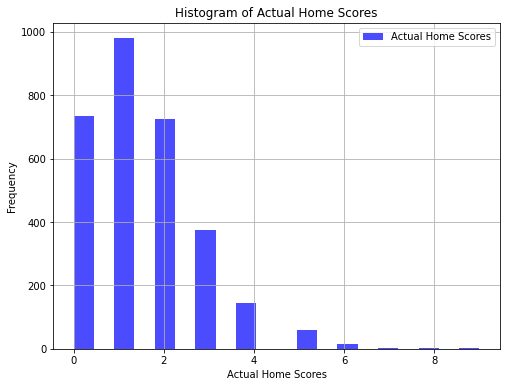

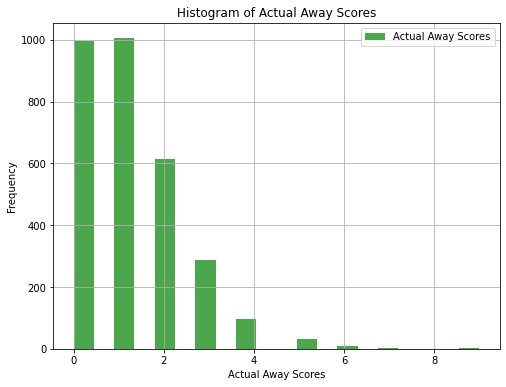

In [113]:
# Plot histogram for actual home scores
plt.figure(figsize=(8, 6))
plt.hist(train['home_score'], bins=20, color='blue', alpha=0.7, label='Actual Home Scores')
plt.xlabel('Actual Home Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Home Scores')
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram for actual away scores
plt.figure(figsize=(8, 6))
plt.hist(train['away_score'], bins=20, color='green', alpha=0.7, label='Actual Away Scores')
plt.xlabel('Actual Away Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Away Scores')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
train['label'] = 0
test['label'] = 0

train['GD'] = train['home_score'] - train['away_score']
test['GD'] = test['home_score'] - test['away_score']
#try later with both poisson and different regressions
ytrain_home = train['home_score']
ytrain_away = train['away_score']

ytest_home = test['home_score']
ytest_away = test['away_score']
# Dropping the columns


train.drop(['home_score', 'away_score'], axis=1, inplace=True)
test.drop(['home_score', 'away_score'], axis=1, inplace=True)


train.loc[train['GD'] > 0, 'label'] = 1
test.loc[test['GD'] > 0, 'label'] = 1

train.loc[train['GD'] < 0, 'label'] = -1

test.loc[test['GD'] < 0, 'label'] = -1


# Saving the gd as y_reg (y regression)

y_train_reg = train['GD']
y_test_reg = test['GD']

y_train = train['label']
y_test = test['label']



train.drop(['GD', 'label'], axis=1, inplace=True)
test.drop(['GD', 'label'], axis=1, inplace=True)


In [115]:
def get_versus(df, attributes, statistics):
    versus_df = pd.DataFrame()
    for att in attributes:
        for stat in statistics:
            versus_df[att+'_'+att+"__"+stat] = df['HomePlayer_'+att+'_'+stat] - df['AwayPlayer_'+att+'_'+stat]
    return versus_df

In [116]:
train.dropna(axis=0).shape

(3040, 83)

In [117]:
train.shape

(3040, 83)

In [118]:
train.head()

,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,HomePlayer_Overall_mean,HomePlayer_Overall_min,HomePlayer_Overall_max,AwayPlayer_Overall_mean,AwayPlayer_Overall_min,AwayPlayer_Overall_max,home_Points_prior,away_Points_prior,HomePlayer_Overall_sd,AwayPlayer_Overall_sd,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,home_GD_form_pw,away_GD_form_pw,home_Points_form_pw,away_Points_form_pw,Matchweek,Home_min_max,Away_min_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.272727,66,86,71.909091,69,74,63.0,42.0,7.785768,1.513575,4.355475,8.836876,4.275201,8.479495,0.000000,-0.571429,1.428571,0.571429,38,5676,5106
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.636364,74,87,73.818182,62,77,68.0,17.0,4.006812,4.261882,4.401164,9.032785,4.299952,8.588280,0.428571,-0.714286,1.428571,0.142857,38,6438,4774
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.818182,64,89,72.909091,70,76,49.0,80.0,6.983096,1.972539,4.388516,8.981790,4.288882,8.537974,-0.285714,1.142857,0.714286,1.571429,38,5696,5320
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.181818,63,83,72.727273,68,76,44.0,34.0,5.306942,2.611165,4.356692,8.837015,4.286122,8.526765,-1.142857,-0.571429,0.857143,0.428571,38,5229,5168
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [119]:
to_log = ['Overall', 'Height', 'Weight']
'''
for col in train.columns:
    for t in to_log:
        if t in col:
            train[col] = np.log2(train[col])
            test[col] = np.log2(test[col])
'''
#versus_train = get_versus(train, to_log, ['mean','min','max','sd'])
#versus_test = get_versus(test, to_log, ['mean','min','max','sd'])


'\nfor col in train.columns:\n    for t in to_log:\n        if t in col:\n            train[col] = np.log2(train[col])\n            test[col] = np.log2(test[col])\n'

In [120]:
for col in train.columns:
    if col not in test.columns:
        print(col)
        print(test.columns)

In [121]:
train.to_csv('X_train.csv')
y_train.to_csv("Y_train.csv")
test.to_csv('X_train.csv')
y_test.to_csv("Y_train.csv")

test.to_csv("X_test.csv")
y_test.to_csv("Y_test.csv")

In [122]:
normal_var = ['HomePlayer_Overall_mean', 'HomePlayer_bench_Overall_mean',
              'Awaylayer_Overall_mean', 'AwayPlayer_bench_Overall_mean',
              'HomePlayer_Age_mean', 'AwayPlayer_Age_mean', 'HomePlayer_Height_mean',
              'AwayPlayer_Height_mean', 'HomePlayer_bench_Height_mean',
              'AwayPlayer_bench_Height_mean']

In [123]:
#train, y_train, y_train_reg, ytrain_home, ytrain_away = remove_outliers_iqr_rows(train, normal_var,
                                                                                 #y_train_reg, y_train,
                                                                                 #ytrain_home, ytrain_away)

In [124]:
print(train.shape)

(3040, 83)


In [125]:
print(y_train_reg.shape)

(3040,)


In [126]:

# Standardize the data for numeric columns
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)

test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns)


Text(0, 0.5, 'Density')

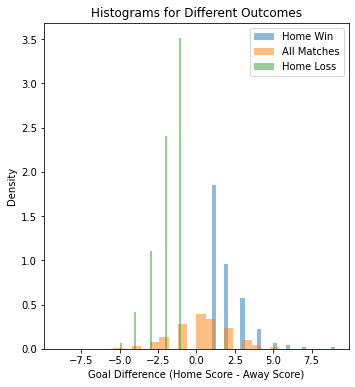

In [127]:

# Separate the data based on labels
home_win_data = y_test_reg[y_test == 1]
home_loss = y_test_reg[y_test == -1]

# Create histograms
plt.figure(figsize=(12, 6))

# Plot histograms
plt.subplot(1, 2, 1)
plt.hist(home_win_data, bins=30, alpha=0.5, label='Home Win', density=True)
plt.hist(y_train_reg, bins=30, alpha=0.5, label='All Matches', density=True)
plt.hist(home_loss, bins=30, alpha=0.5, label='Home Loss', density=True)
plt.legend()
plt.title('Histograms for Different Outcomes')
plt.xlabel('Goal Difference (Home Score - Away Score)')
plt.ylabel('Density')



Text(0, 0.5, 'Density')

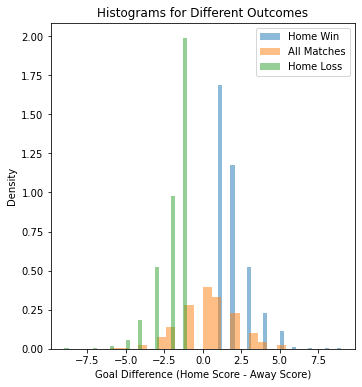

In [128]:

# Separate the data based on labels
home_win_data = y_train_reg[y_train == 1]
home_loss = y_train_reg[y_train == -1]

# Create histograms
plt.figure(figsize=(12, 6))

# Plot histograms
plt.subplot(1, 2, 1)
plt.hist(home_win_data, bins=30, alpha=0.5, label='Home Win', density=True)
plt.hist(y_train_reg, bins=30, alpha=0.5, label='All Matches', density=True)
plt.hist(home_loss, bins=30, alpha=0.5, label='Home Loss', density=True)
plt.legend()
plt.title('Histograms for Different Outcomes')
plt.xlabel('Goal Difference (Home Score - Away Score)')
plt.ylabel('Density')



Outlier Detection

# A different way to predict:

We can try to treat this as a classification problem, which it is, but we can also try another approach:

We can try to predict the goal difference in the match, and use that value to predict the probability of a win - tie - loss.

Intuition: if we predict for example the home team to win by more than 3 goals, we give a high probability for the home team to win and likewise for the away team.
If however we predict a very close game, we give a high probability for a tie.

What we need is to take the best regression model, and with that (and with some assumptions) we can extract the probabilities.

In [129]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=0)

xgb_cv = GridSearchCV(estimator=xgb_clf,
                      param_grid={'max_depth':  [1, 3, 5],
                                  'learning_rate': [0.01, 0.001, 0.1],
                                  'colsample_bytree': [.3, 0.5, 0.7],
                                  'colsample_bylevel':[.3, 0.5, 0.7],
                                  'colsample_bynode' :[.3, 0.5, 0.7],
                                  'n_estimators' : [50, 100, 150]},
                      scoring='roc_auc_ovr',
                      cv=5, verbose=3)
xgb_train = y_train.replace(1, 2).replace(0, 1).replace(-1, 0)
xgb_test = y_test.replace(1, 2).replace(0, 1).replace(-1, 0)
xgb_cv.fit(train, xgb_train)
print(xgb_cv.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 1/5] END colsample_bylevel=0.3, colsample_bynode=0.3, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=50;, score=0.600 total time=   0.0s
[CV 2/5] END colsample_bylevel=0.3, colsample_bynode=0.3, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=50;, score=0.660 total time=   0.0s
[CV 3/5] END colsample_bylevel=0.3, colsample_bynode=0.3, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=50;, score=0.676 total time=   0.0s
[CV 4/5] END colsample_bylevel=0.3, colsample_bynode=0.3, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=50;, score=0.637 total time=   0.1s
[CV 5/5] END colsample_bylevel=0.3, colsample_bynode=0.3, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=50;, score=0.633 total time=   0.0s
[CV 1/5] END colsample_bylevel=0.3, colsample_bynode=0.3, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=

<Figure size 2160x2160 with 0 Axes>

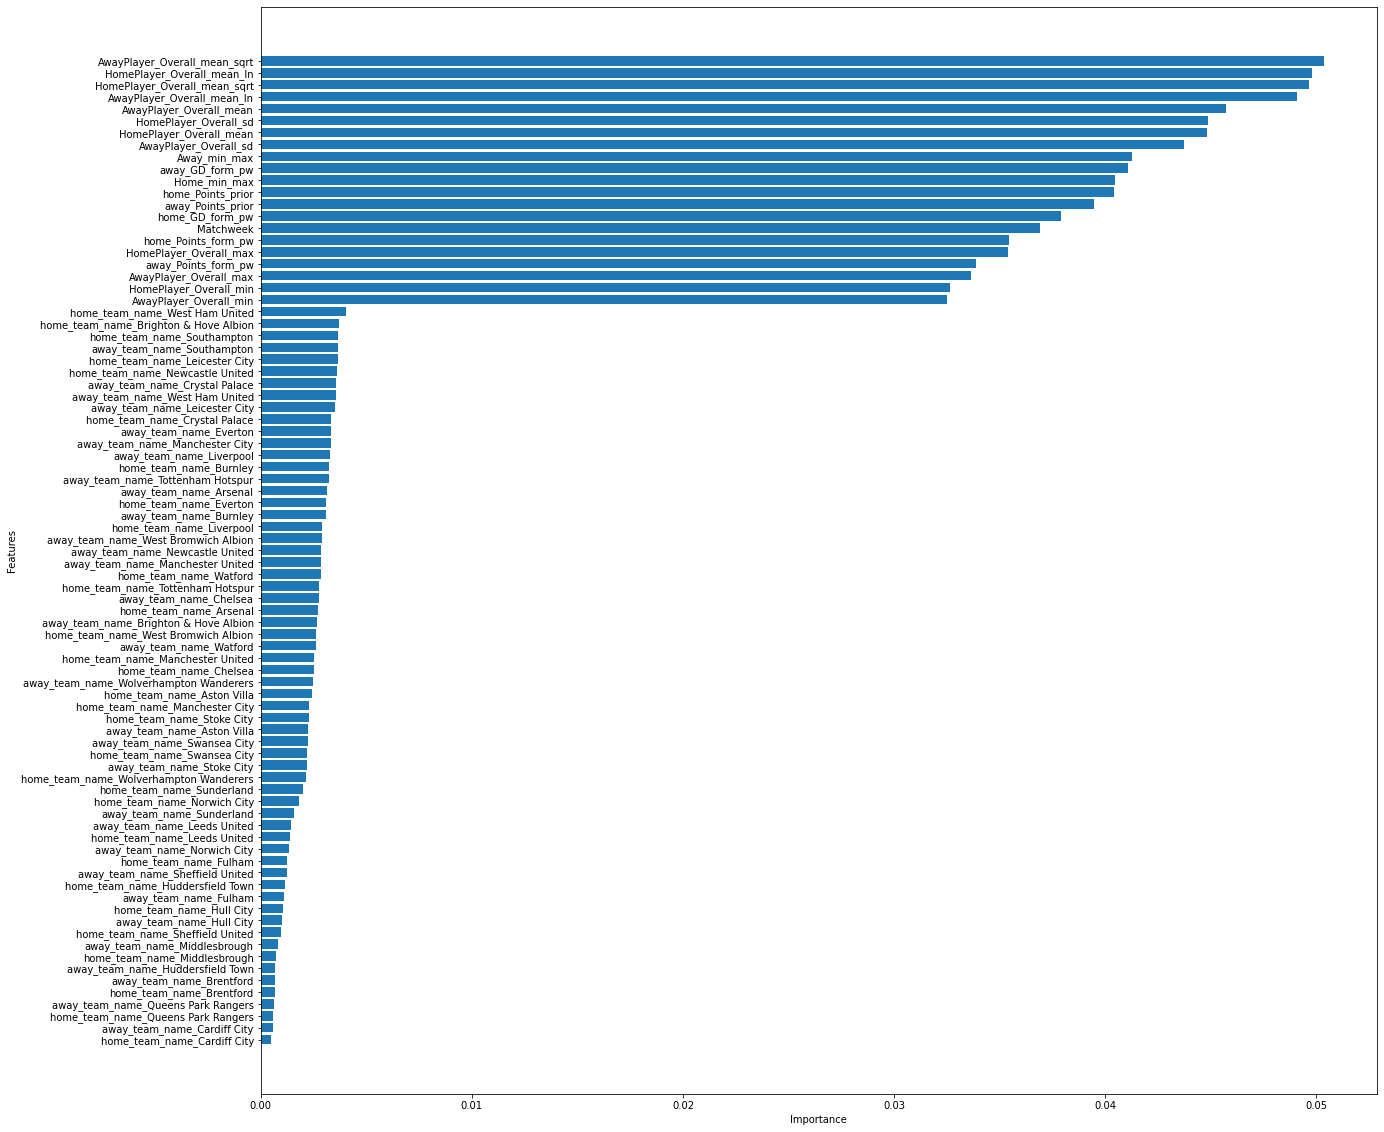

<Figure size 2160x2160 with 0 Axes>

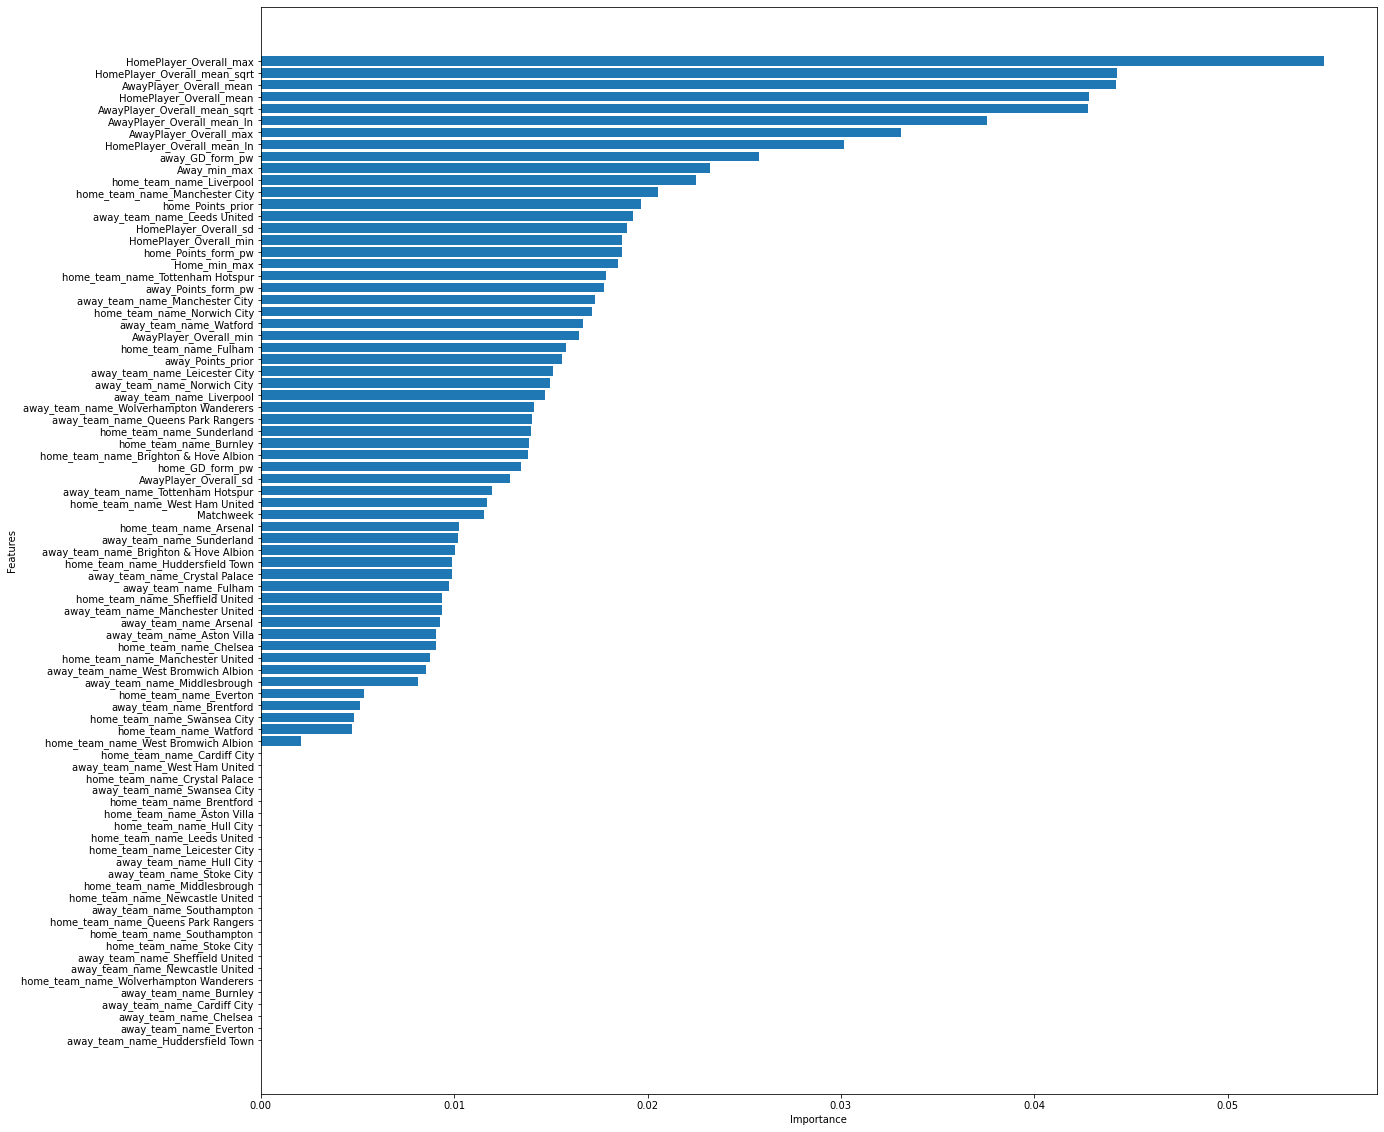

In [130]:
# Plot feature importance
plt.figure(figsize=(30, 30,))  # Adjust the size as needed
feature_names = xgb_cv.best_estimator_.feature_names_in_
importances = xgb_cv.best_estimator_.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order of importance

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(20, 20))  # Adjust the size as needed

plt.barh(range(len(sorted_importances)), sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)  # Set the sorted feature names as y-axis labels
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [170]:
train_probas = xgb_cv.predict_proba(train)
test_probas = xgb_cv.predict_proba(test)

In [171]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Calculate OvO AUC for the training set


train_auc_ovr = roc_auc_score(xgb_train, train_probas, multi_class='ovr')
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(xgb_test, test_probas, multi_class='ovr')
print(f"Test OvR AUC: {test_auc_ovr}")

Training OvR AUC: 0.7637416839690054
Test OvR AUC: 0.6173612957586216


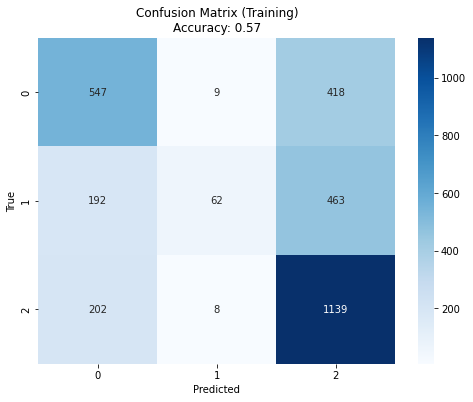

In [173]:

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes

# Create a confusion matrix
conf_matrix = confusion_matrix(xgb_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(xgb_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()


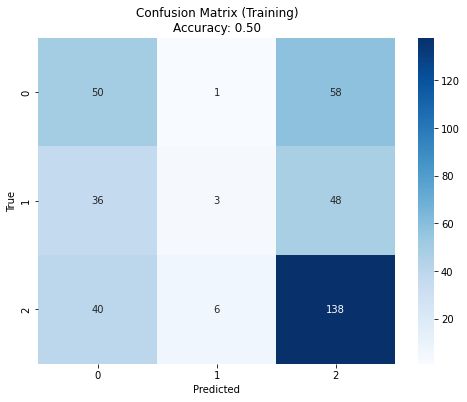

In [177]:

test_classes = np.argmax(test_probas, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(xgb_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(xgb_test, test_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()


NOTE! we see there is one problem with the accuracy score, the tie, if we take this conf matrix and see the accuracy when we care about win or not wins we get 60% accuracy

if we look at accuracy between loss and not loss we get 65% accuracy.

this is with hand waving, but what it gives us an intuition for 2 ways for modeling:

1. ordered models - such as probit and logit, we take into account the order between the labels
2. nested models - we first can calculate the odds of winning, and when we know we won't win, what is the probability of a tie and a loss

In [135]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000)

rf_cv = GridSearchCV(estimator=rf_clf,
                      param_grid={'max_features' : ['sqrt', 'log2', 1/3, 'auto']},
                      scoring='roc_auc_ovr',
                      cv=5, verbose=3)

rf_cv.fit(train, xgb_train)
print(rf_cv.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .................max_features=sqrt;, score=0.622 total time=   6.3s
[CV 2/5] END .................max_features=sqrt;, score=0.688 total time=   6.2s
[CV 3/5] END .................max_features=sqrt;, score=0.667 total time=   6.2s
[CV 4/5] END .................max_features=sqrt;, score=0.617 total time=   6.0s
[CV 5/5] END .................max_features=sqrt;, score=0.619 total time=   6.0s
[CV 1/5] END .................max_features=log2;, score=0.623 total time=   5.4s
[CV 2/5] END .................max_features=log2;, score=0.690 total time=   6.0s
[CV 3/5] END .................max_features=log2;, score=0.674 total time=   5.3s
[CV 4/5] END .................max_features=log2;, score=0.618 total time=   5.3s
[CV 5/5] END .................max_features=log2;, score=0.619 total time=   5.5s
[CV 1/5] END ...max_features=0.3333333333333333;, score=0.620 total time=  13.7s
[CV 2/5] END ...max_features=0.3333333333333333;,

c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END .................max_features=auto;, score=0.619 total time=   6.1s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END .................max_features=auto;, score=0.691 total time=   6.2s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END .................max_features=auto;, score=0.670 total time=   6.3s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END .................max_features=auto;, score=0.615 total time=   6.1s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END .................max_features=auto;, score=0.617 total time=   6.1s
0.644781859335368


<Figure size 2160x2160 with 0 Axes>

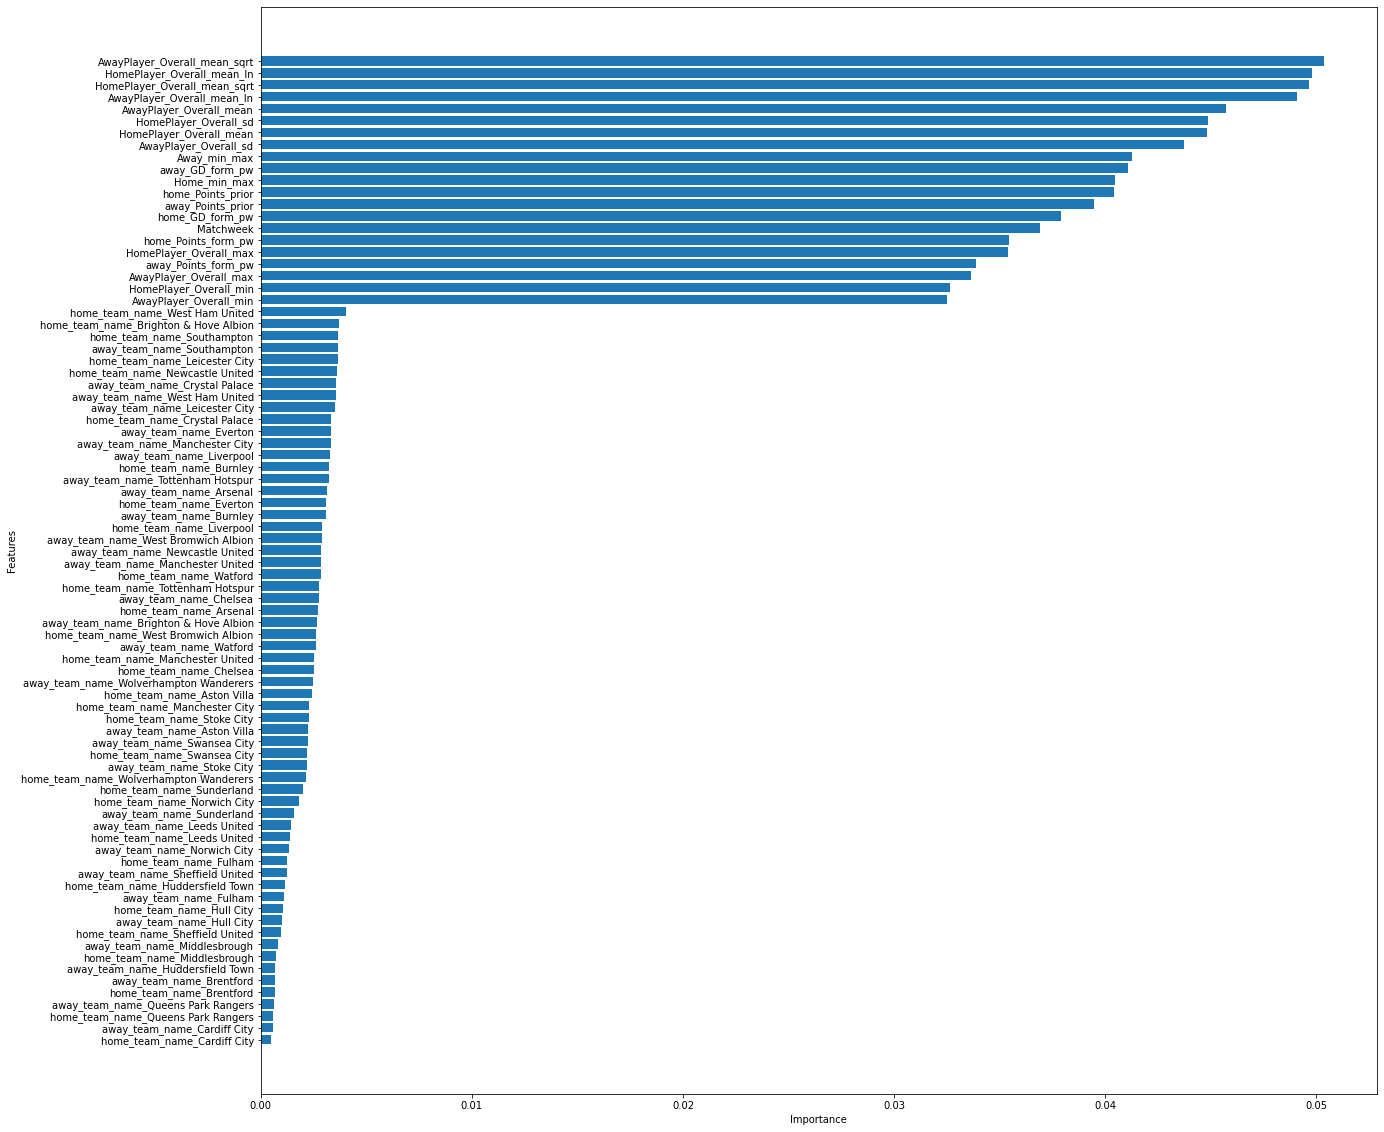

In [168]:
# Plot feature importance
plt.figure(figsize=(30, 30,))  # Adjust the size as needed
feature_names = rf_cv.best_estimator_.feature_names_in_
importances = rf_cv.best_estimator_.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order of importance

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(20, 20))  # Adjust the size as needed

plt.barh(range(len(sorted_importances)), sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)  # Set the sorted feature names as y-axis labels
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [ ]:
train_probas = rf_cv.predict_proba(train)
test_probas = rf_cv.predict_proba(test)


# Use np.argmax along axis 1 to get the index of the maximum probability for each sample
predictions = np.argmax(test_probas, axis=1)

# Convert the indices to the actual classes (-1, 0, 1)
predictions = predictions - 1

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes - 1
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix using a heatmap
accuracy = accuracy_score(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix training\nAccuracy: '+ str(accuracy))
plt.show()

In [136]:
from sklearn.linear_model import Ridge, Lasso

gd_lasso = Lasso(max_iter=20000)

lasso_gd = GridSearchCV(estimator= gd_lasso,
                        param_grid={'alpha' : [.000001, 0.0001, 0.001, 0.01, 0.1, 1, 0.5, 0.2],
                                    'fit_intercept' : [True, False]},
                          scoring='neg_mean_squared_error',
                          cv=5)

gd_ridge = Ridge(max_iter=20000)

ridge_cv = GridSearchCV(estimator= gd_ridge,
                        param_grid={'alpha' : [.000001, 0.0001, 0.001, 0.01, 0.1, 1, 0.5, 0.2],
                                    'fit_intercept' : [True, False]},
                          scoring='neg_mean_squared_error',
                          cv=3)

lasso_gd.fit(train_scaled, y_train_reg)
ridge_cv.fit(train_scaled, y_train_reg)
print('MSE for lasso:', lasso_gd.best_score_)
print("Lasso Parameters:", lasso_gd.best_params_)
print('MSE for ridge:', ridge_cv.best_score_)
print("Ridge Parameters:", ridge_cv.best_params_)

c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e+03, tolerance: 8.535e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.970e+03, tolerance: 8.360e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.650e+03, toleranc

MSE for lasso: -2.821506107413664
Lasso Parameters: {'alpha': 0.1, 'fit_intercept': True}
MSE for ridge: -2.81758420194846
Ridge Parameters: {'alpha': 1, 'fit_intercept': True}


In [137]:

from scipy.stats import norm, skellam
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score




def extract_poisson_probas(home_pred, away_pred):
    '''
    creates a probability matrix according to the regression

    Parameters:
    home_pred: expected home score
    away_pred: expected away score
    '''

    probability_matrix = np.zeros((len(home_pred), 3))  # 3 columns (-1, 0, 1 probabilities)
    
    for i in range(len(home_pred)):
        # Check for NaN values and skip the calculation if found
        if np.isnan(home_pred[i]) or np.isnan(away_pred[i]):
            continue

        home_rounded = home_pred[i]
        away_rounded = away_pred[i]
        
        diff = skellam(home_rounded, away_rounded)
        
        probability_matrix[i, 0] = diff.cdf(-1)
        probability_matrix[i, 1] = diff.pmf(0)
        probability_matrix[i, 2] = 1 - diff.cdf(0)
        if(probability_matrix[i, 0] == np.nan or probability_matrix[i, 1] == np.nan or probability_matrix[i, 2] == np.nan):
            print("NAN PRODUCED IN INDEX", i)
        
    return probability_matrix


    
def extract_probas(pred, sd, upper_threshold, lower_threshold):
    '''
    creates a probability matrix according to the regression

    Parameters:
    pred: the prediction from the regression
    sd: Standard Deviation for the variable
    bias: Here will be the mean of the goal differences (takes into account home advantage)
    '''

    
    probability_matrix = np.zeros((len(pred), 3)) # 3 columns (-1, 0, 1 probabilities)
    for i in range(len(pred)):
        probability_matrix[i, 0] = norm.cdf(lower_threshold, loc=pred[i], scale=sd)
        probability_matrix[i, 1] = norm.cdf(upper_threshold, loc=pred[i], scale=sd) - probability_matrix[i, 0]
        probability_matrix[i, 2] = 1 - probability_matrix[i, 1] - probability_matrix[i, 0]
        
    return probability_matrix



In [138]:
train_pred = lasso_gd.predict(train)
train_probas = extract_probas(train_pred, 1.6, .5,-.3)
test_pred = lasso_gd.predict(test)
test_probas = extract_probas(test_pred, 1.6, .5,-.3)

In [139]:
test_probas.shape

(380, 3)

In [140]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier


knn_cv = GridSearchCV(estimator=KNeighborsRegressor(),
                      param_grid={"n_neighbors" : list(range(1, 100, 5))},
                      scoring='neg_mean_squared_error')
knn_cv.fit(train, y_train_reg)
print("Parameters:",knn_cv.best_params_)
print("CV Score:", knn_cv.best_score_)

Parameters: {'n_neighbors': 96}
CV Score: -3.1545013606199745


In [141]:
mean_win = y_train_reg[y_train_reg  > 0].mean()
mean_loss = y_train_reg[y_train_reg < 0].mean()

print("Average GD when the home team wins", mean_win)
print("Average GD when the home team loses", mean_loss)

Average GD when the home team wins 1.9325426241660488
Average GD when the home team loses -1.7833675564681726


How should we wheigh our predictions?

If we don't "wheigh" (meaning we just preform a regression and extract probas) we can confuse between tie and loss, as per the density plots.

so meaning, if our expected home goals and away goals are such that we don't predict a win, lets penalize the home team

In [142]:
train_probas.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [143]:
print(train_probas)

[[7.03505766e-16 3.51128256e-14 1.00000000e+00]
 [1.70197249e-16 9.26653249e-15 1.00000000e+00]
 [9.42779727e-15 3.99286078e-13 1.00000000e+00]
 ...
 [9.77880473e-05 5.32816519e-04 9.99369395e-01]
 [1.35233535e-11 3.46056733e-10 1.00000000e+00]
 [1.97296388e-04 9.71244689e-04 9.98831459e-01]]


In [144]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Calculate OvO AUC for the training set


train_auc_ovr = roc_auc_score(y_train, train_probas, multi_class='ovr')
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas, multi_class='ovr')
print(f"Test OvR AUC: {test_auc_ovr}")

Training OvR AUC: 0.6453240778780588
Test OvR AUC: 0.6360320300550236


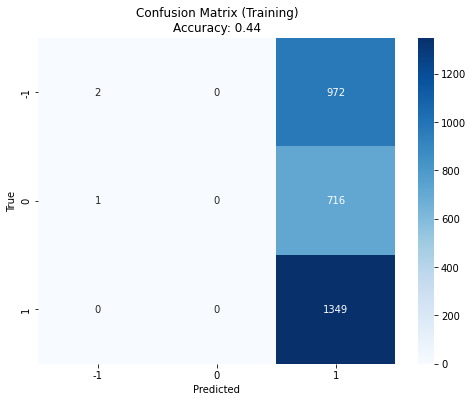

In [145]:

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes - 1

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()


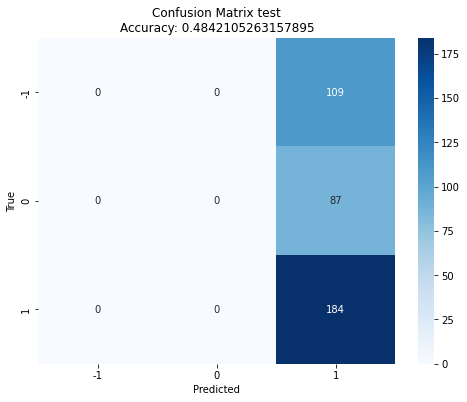

In [146]:
from sklearn.metrics import confusion_matrix

# Use np.argmax along axis 1 to get the index of the maximum probability for each sample
predictions = np.argmax(test_probas, axis=1)

# Convert the indices to the actual classes (-1, 0, 1)
predictions = predictions - 1

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes - 1
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix using a heatmap
accuracy = accuracy_score(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix test\nAccuracy: '+ str(accuracy))
plt.show()

In [147]:
# we will see how this compares to betting odds auc

betting_data = pd.read_csv("E0.csv")

#betting_data = betting_data[['B365H', 'B365D', 'B365A']]
#betting_data.shape



In [148]:
betting_data['FTR'].replace('A', -1, inplace=True)
betting_data['FTR'].replace('H', 1, inplace=True)
betting_data['FTR'].replace('D', 0, inplace=True)

In [149]:

betting_data = betting_data[['B365H', 'B365D', 'B365A','FTR']]


In [150]:
actual = betting_data['FTR']


In [151]:
probas = betting_data[['B365A', 'B365D', 'B365H']] 
bet_sum = np.sum(probas, axis=1)

normalized_probas = np.array(1 / probas)


In [152]:
normalized_probas
bet_sum = np.sum(normalized_probas, axis=1).reshape(-1, 1)

In [153]:
normalized_probas /= bet_sum

In [154]:
normalized_probas

array([[0.51167513, 0.26294416, 0.22538071],
       [0.75644699, 0.15759312, 0.08595989],
       [0.47511312, 0.27149321, 0.25339367],
       ...,
       [0.26094772, 0.24721363, 0.49183864],
       [0.15660036, 0.21699819, 0.62640145],
       [0.6558683 , 0.19883165, 0.14530005]])

In [155]:
betting_odds_auc = roc_auc_score(actual, normalized_probas, multi_class='ovr')
print(f"betting odds AUC: {betting_odds_auc}")

betting odds AUC: 0.6666565905809213


In [156]:
test_probas

array([[1.32380066e-13, 4.70689902e-12, 1.00000000e+00],
       [2.03842623e-12, 5.99053057e-11, 1.00000000e+00],
       [9.77080159e-06, 7.18317253e-05, 9.99918397e-01],
       ...,
       [1.34436677e-08, 1.95543432e-07, 9.99999791e-01],
       [2.70169505e-02, 4.98357516e-02, 9.23147298e-01],
       [4.21723236e-03, 1.21974320e-02, 9.83585336e-01]])

In [157]:
normalized_probas = np.array(normalized_probas)

In [158]:
normalized_probas

array([[0.51167513, 0.26294416, 0.22538071],
       [0.75644699, 0.15759312, 0.08595989],
       [0.47511312, 0.27149321, 0.25339367],
       ...,
       [0.26094772, 0.24721363, 0.49183864],
       [0.15660036, 0.21699819, 0.62640145],
       [0.6558683 , 0.19883165, 0.14530005]])

In [159]:
bo_classes = np.argmax(normalized_probas, axis=1)-1

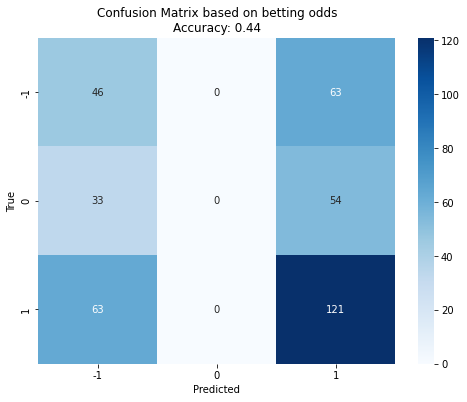

In [160]:
# Create a confusion matrix

conf_matrix = confusion_matrix(y_test, bo_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, bo_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix based on betting odds\nAccuracy: {accuracy:.2f}')
plt.show()


In [161]:
test_probas

array([[1.32380066e-13, 4.70689902e-12, 1.00000000e+00],
       [2.03842623e-12, 5.99053057e-11, 1.00000000e+00],
       [9.77080159e-06, 7.18317253e-05, 9.99918397e-01],
       ...,
       [1.34436677e-08, 1.95543432e-07, 9.99999791e-01],
       [2.70169505e-02, 4.98357516e-02, 9.23147298e-01],
       [4.21723236e-03, 1.21974320e-02, 9.83585336e-01]])

In [162]:
test_probas - np.asarray(normalized_probas)

array([[-0.51167513, -0.26294416,  0.77461929],
       [-0.75644699, -0.15759312,  0.91404011],
       [-0.47510335, -0.27142138,  0.74652473],
       ...,
       [-0.26094771, -0.24721344,  0.50816115],
       [-0.12958341, -0.16716244,  0.29674585],
       [-0.65165106, -0.18663422,  0.83828528]])

In [163]:

classes = np.argmax(test_probas - np.asarray(normalized_probas), axis=1)


In [164]:
classes -=1

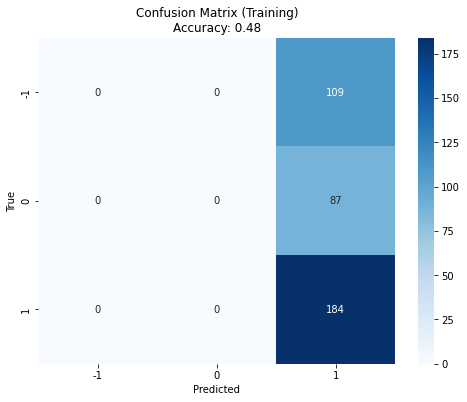

In [165]:

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()


Lets see how good our model is using orderd probit / logit


In [179]:
train_scaled

,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,HomePlayer_Overall_mean,HomePlayer_Overall_min,HomePlayer_Overall_max,AwayPlayer_Overall_mean,AwayPlayer_Overall_min,AwayPlayer_Overall_max,home_Points_prior,away_Points_prior,HomePlayer_Overall_sd,AwayPlayer_Overall_sd,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,home_GD_form_pw,away_GD_form_pw,home_Points_form_pw,away_Points_form_pw,Matchweek,Home_min_max,Away_min_max
0,-0.229416,-0.179605,-0.079305,-0.179605,-0.213896,-0.079305,-0.229416,-0.229416,-0.229416,-0.112509,-0.112509,-0.112509,-0.112509,-0.229416,-0.229416,-0.229416,4.358899,-0.079305,-0.213896,-0.138233,-0.079305,-0.112509,-0.229416,-0.160128,-0.138233,-0.160128,-0.229416,-0.197386,-0.179605,-0.229416,-0.160128,-0.229416,-0.179605,-0.079305,-0.179605,-0.213896,-0.079305,-0.229416,-0.229416,-0.229416,-0.112509,-0.112509,-0.112509,-0.112509,-0.229416,-0.229416,-0.229416,-0.229416,-0.079305,-0.213896,-0.138233,-0.079305,-0.112509,-0.229416,-0.160128,-0.138233,-0.160128,-0.229416,-0.197386,-0.179605,-0.229416,-0.160128,0.294622,-0.526002,0.818315,-1.467236,-0.024919,-1.958758,2.024692,0.884903,2.211823,-1.431078,0.246748,0.271031,-1.473953,-1.471826,0.020714,-0.780411,0.889553,-0.732018,1.658250,-0.061649,-0.894005
1,4.358899,-0.179605,-0.079305,-0.179605,-0.213896,-0.079305,-0.229416,-0.229416,-0.229416,-0.112509,-0.112509,-0.112509,-0.112509,-0.229416,-0.229416,-0.229416,-0.229416,-0.079305,-0.213896,-0.138233,-0.079305,-0.112509,-0.229416,-0.160128,-0.138233,-0.160128,-0.229416,-0.197386,-0.179605,-0.229416,-0.160128,-0.229416,5.567764,-0.079305,-0.179605,-0.213896,-0.079305,-0.229416,-0.229416,-0.229416,-0.112509,-0.112509,-0.112509,-0.112509,-0.229416,-0.229416,-0.229416,-0.229416,-0.079305,-0.213896,-0.138233,-0.079305,-0.112509,-0.229416,-0.160128,-0.138233,-0.160128,-0.229416,-0.197386,-0.179605,-0.229416,-0.160128,1.241262,0.784289,1.050895,-0.934639,-1.172707,-1.263097,2.294322,-0.463926,0.032480,0.180364,1.244063,1.243038,-0.939074,-0.937133,0.585076,-0.970698,0.889553,-1.511476,1.658250,1.071293,-1.384958
2,-0.229416,-0.179605,-0.079305,-0.179605,-0.213896,-0.079305,4.358899,-0.229416,-0.229416,-0.112509,-0.112509,-0.112509,-0.112509,-0.22

In [207]:
train.columns

Index(['home_team_name_Arsenal', 'home_team_name_Aston Villa', 'home_team_name_Brentford', 'home_team_name_Brighton & Hove Albion', 'home_team_name_Burnley', 'home_team_name_Cardiff City', 'home_team_name_Chelsea', 'home_team_name_Crystal Palace', 'home_team_name_Everton', 'home_team_name_Fulham', 'home_team_name_Huddersfield Town', 'home_team_name_Hull City', 'home_team_name_Leeds United', 'home_team_name_Leicester City', 'home_team_name_Liverpool', 'home_team_name_Manchester City', 'home_team_name_Manchester United', 'home_team_name_Middlesbrough', 'home_team_name_Newcastle United', 'home_team_name_Norwich City', 'home_team_name_Queens Park Rangers', 'home_team_name_Sheffield United', 'home_team_name_Southampton', 'home_team_name_Stoke City', 'home_team_name_Sunderland', 'home_team_name_Swansea City', 'home_team_name_Tottenham Hotspur', 'home_team_name_Watford', 'home_team_name_West Bromwich Albion', 'home_team_name_West Ham United', 'home_team_name_Wolverhampton Wanderers',
       '

In [208]:

from statsmodels.miscmodels.ordinal_model import OrderedModel
### to make our lives easier

home_teams = []
for col in train_scaled.columns:
    if 'home_team_name' in col:
        home_teams.append(col)

away_teams = []
for col in train_scaled.columns:
    if 'away_team_name' in col:
        home_teams.append(col)
form_and_matchweek = ['home_GD_form_pw', 'away_GD_form_pw', 'home_Points_form_pw', 'away_Points_form_pw', 'Matchweek', 'Home_min_max', 'Away_min_max']
mod_log = OrderedModel(y_train,train_scaled[['HomePlayer_Overall_mean', 'HomePlayer_Overall_sd',
                                     'AwayPlayer_Overall_mean', 'AwayPlayer_Overall_sd']
                                     + home_teams + away_teams + form_and_matchweek],
                        
                        distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  label   Log-Likelihood:                -2896.5
Model:                   OrderedModel   AIC:                             5943.
Method:            Maximum Likelihood   BIC:                             6394.
Date:                Tue, 20 Feb 2024                                         
Time:                        19:29:20                                         
No. Observations:                3040                                         
Df Residuals:                    2965                                         
Df Model:                          73                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
HomePlayer_Overall_mean                    0.2620      0.129      2.035      0.042       0.010       0.514
HomePlayer_Overall_sd                      0.0649      0.080      0.810      0.418      -0.092       0.222
AwayPlayer_Overall_mean                   -0.2561      0.124     -2.061      0.039      -0.500      -0.012
AwayPlayer_Overall_sd                      0.0811      0.075      1.077      0.281      -0.066       0.229
home_team_name_Arsenal                     0.1779      0.066      2.698      0.007       0.049       0.307
home_team_name_Aston Villa                -0.0845      0.049     -1.728      0.084      -0.180       0.011
home_team_name_Brentford                   0.0046      0.040      0.116      0.908      -0.074       0.083
home_team_name_Brighton & Hove Albion     -0.0332      0.048     -0.693      0.488      -0.127       0.061
home_team_name_Burnley                    -0.0388      0.053     -0.737      0.461      -0.142       0.064
home_team_name_Cardiff City               -0.0405      0.041     -0.995      0.320      -0.120       0.039
home_team_name_Chelsea                     0.1025      0.069      1.481      0.139      -0.033       0.238
home_team_name_Crystal Palace             -0.0701      0.055     -1.274      0.203      -0.178       0.038
home_team_name_Everton                     0.0244      0.059      0.415      0.678      -0.091       0.140
home_team_name_Fulham                     -0.0973      0.043     -2.271      0.023      -0.181      -0.013
home_team_name_Huddersfield Town          -0.0953      0.043     -2.226      0.026      -0.179      -0.011
home_team_name_Hull City                  -0.0175      0.041     -0.427      0.669      -0.098       0.063
home_team_name_Leeds United               -0.0050      0.040     -0.123      0.902      -0.084       0.074
home_team_name_Leicester City              0.0689      0.057      1.217      0.224      -0.042       0.180
home_team_name_Liverpool                   0.1986      0.069      2.859      0.004       0.062       0.335
home_team_name_Manchester City             0.2371      0.076      3.099      0.002       0.087       0.387
home_team_name_Manchester United           0.1204      0.069      1.736      0.083      -0.016       0.256
home_team_name_Middlesbrough              -0.0348      0.037     -0.928      0.353      -0.108       0.039
home_team_name_Newcastle United            0.0010      0.053      0.019      0.985      -0.102       0.104
home_team_name_Norwich City               -0.0856      0.046     -1.877      0.061      -0.175       0.004
home_team_name_Queens Park Rangers        -0.0160      0.038     -0.424      0.671      -0.090       0.058
home_team_name_Sheffield United           -0.0273      0.043     -0.633      0.527      -0.112       0.057
home_team_name_Southampton                -0.0068      0.05

In [211]:

mod_prob = OrderedModel(y_train,train_scaled[['HomePlayer_Overall_mean', 'HomePlayer_Overall_sd',
                                     'AwayPlayer_Overall_mean', 'AwayPlayer_Overall_sd']
                                     + home_teams + away_teams+ form_and_matchweek],
                        
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs', disp=False)
res_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  label   Log-Likelihood:                -2897.2
Model:                   OrderedModel   AIC:                             5944.
Method:            Maximum Likelihood   BIC:                             6396.
Date:                Tue, 20 Feb 2024                                         
Time:                        19:30:08                                         
No. Observations:                3040                                         
Df Residuals:                    2965                                         
Df Model:                          73                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
HomePlayer_Overall_mean                    0.1563      0.077      2.044      0.041       0.006       0.306
HomePlayer_Overall_sd                      0.0360      0.048      0.754      0.451      -0.058       0.130
AwayPlayer_Overall_mean                   -0.1485      0.075     -1.985      0.047      -0.295      -0.002
AwayPlayer_Overall_sd                      0.0403      0.045      0.887      0.375      -0.049       0.129
home_team_name_Arsenal                     0.1091      0.040      2.743      0.006       0.031       0.187
home_team_name_Aston Villa                -0.0506      0.030     -1.696      0.090      -0.109       0.008
home_team_name_Brentford                  -0.0001      0.024     -0.004      0.996      -0.047       0.047
home_team_name_Brighton & Hove Albion     -0.0168      0.029     -0.569      0.570      -0.075       0.041
home_team_name_Burnley                    -0.0227      0.032     -0.704      0.482      -0.086       0.041
home_team_name_Cardiff City               -0.0240      0.024     -0.980      0.327      -0.072       0.024
home_team_name_Chelsea                     0.0683      0.042      1.626      0.104      -0.014       0.151
home_team_name_Crystal Palace             -0.0424      0.034     -1.264      0.206      -0.108       0.023
home_team_name_Everton                     0.0129      0.036      0.361      0.718      -0.057       0.083
home_team_name_Fulham                     -0.0597      0.026     -2.297      0.022      -0.111      -0.009
home_team_name_Huddersfield Town          -0.0573      0.026     -2.194      0.028      -0.108      -0.006
home_team_name_Hull City                  -0.0093      0.025     -0.372      0.710      -0.058       0.040
home_team_name_Leeds United               -0.0052      0.025     -0.208      0.836      -0.054       0.044
home_team_name_Leicester City              0.0430      0.035      1.245      0.213      -0.025       0.111
home_team_name_Liverpool                   0.1213      0.042      2.910      0.004       0.040       0.203
home_team_name_Manchester City             0.1433      0.046      3.141      0.002       0.054       0.233
home_team_name_Manchester United           0.0752      0.042      1.793      0.073      -0.007       0.157
home_team_name_Middlesbrough              -0.0231      0.023     -0.986      0.324      -0.069       0.023
home_team_name_Newcastle United            0.0039      0.032      0.122      0.903      -0.059       0.067
home_team_name_Norwich City               -0.0513      0.027     -1.868      0.062      -0.105       0.003
home_team_name_Queens Park Rangers        -0.0105      0.023     -0.451      0.652      -0.056       0.035
home_team_name_Sheffield United           -0.0148      0.026     -0.578      0.563      -0.065       0.035
home_team_name_Southampton                -0.0027      0.03

In [212]:
test_probas= res_log.model.predict(res_log.params, exog=test_scaled[['HomePlayer_Overall_mean', 'HomePlayer_Overall_sd',
                                     'AwayPlayer_Overall_mean', 'AwayPlayer_Overall_sd']
                                     + home_teams + away_teams + form_and_matchweek])

train_probas= res_log.model.predict(res_log.params, exog=train_scaled[['HomePlayer_Overall_mean', 'HomePlayer_Overall_sd',
                                     'AwayPlayer_Overall_mean', 'AwayPlayer_Overall_sd']
                                     + home_teams + away_teams + form_and_matchweek])

In [213]:

train_auc_ovr = roc_auc_score(y_train, train_probas, multi_class='ovr')
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas, multi_class='ovr')
print(f"Test OvR AUC: {test_auc_ovr}")

Training OvR AUC: 0.689595236587674
Test OvR AUC: 0.5971019898688591


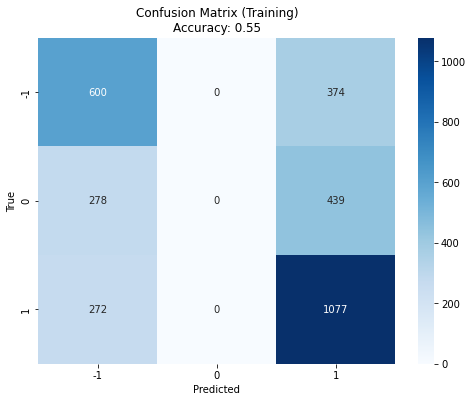

In [214]:

train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes -1 

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0 ,1], yticklabels=[-1, 0 ,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()


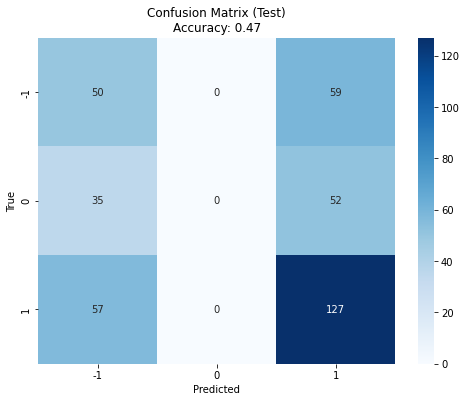

In [215]:

test_classes = np.argmax(test_probas, axis=1)
test_classes = test_classes - 1 

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[-1, 0 ,1], yticklabels=[-1, 0 ,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test)\nAccuracy: {accuracy:.2f}')
plt.show()
